# Collision Avoidance - Train Model (ResNet18)

Welcome to this host side Jupyter Notebook!  This should look familiar if you ran through the notebooks that run on the robot.  In this notebook we'll train our image classifier to detect two classes
``free`` and ``blocked``, which we'll use for avoiding collisions.  For this, we'll use a popular deep learning library *PyTorch*

In [1]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import os

In [2]:
# os.environ['CUDA_LAUNCH_BLOCKING']='1'

### Upload and extract dataset

Before you start, you should upload the ``dataset.zip`` file that you created in the ``data_collection.ipynb`` notebook on the robot.

You should then extract this dataset by calling the command below

In [5]:
!unzip -q dataset.zip

You should see a folder named ``dataset`` appear in the file browser.

### Create dataset instance

Now we use the ``ImageFolder`` dataset class available with the ``torchvision.datasets`` package.  We attach transforms from the ``torchvision.transforms`` package to prepare the data for training.  

In [7]:
dataset = datasets.ImageFolder(
    'dataset',
    transforms.Compose([
        transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)

In [8]:
dataset

Dataset ImageFolder
    Number of datapoints: 399
    Root location: dataset
    StandardTransform
Transform: Compose(
               ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), saturation=(0.9, 1.1), hue=(-0.1, 0.1))
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

### Split dataset into train and test sets

Next, we split the dataset into *training* and *test* sets.  The test set will be used to verify the accuracy of the model we train.

In [9]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - 30, 30])

### Create data loaders to load data in batches

We'll create two ``DataLoader`` instances, which provide utilities for shuffling data, producing *batches* of images, and loading the samples in parallel with multiple workers.

In [10]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0,
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0,
)

### Define the neural network

Now, we define the neural network we'll be training.  The *torchvision* package provides a collection of pre-trained models that we can use.

In a process called *transfer learning*, we can repurpose a pre-trained model (trained on millions of images) for a new task that has possibly much less data available.

Important features that were learned in the original training of the pre-trained model are re-usable for the new task.  We'll use the ``resnet18`` model.

In [5]:
model = models.resnet18(pretrained=True)

The ``resnet18`` model was originally trained for a dataset that had 1000 class labels, but our dataset only has two class labels!  We'll replace
the final layer with a new, untrained layer that has only two outputs.  

In [6]:
model.fc = torch.nn.Linear(512, 2)

Finally, we transfer our model for execution on the GPU

In [7]:
device = torch.device('cuda')
model = model.to(device)

### Train the neural network

Using the code below we will train the neural network for 30 epochs, saving the best performing model after each epoch.

> An epoch is a full run through our data.

In [8]:
NUM_EPOCHS = 30
BEST_MODEL_PATH = 'best_model_resnet18.pth'
best_accuracy = 0.0

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(NUM_EPOCHS):
    
    for images, labels in iter(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels-1)
        loss.backward()
        optimizer.step()
    
    test_error_count = 0.0
    for images, labels in iter(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        test_error_count += float(torch.sum(torch.abs(labels - 1 - outputs.argmax(1))))
    
    test_accuracy = 1.0 - float(test_error_count) / float(len(test_dataset))
    print('%d: %f' % (epoch, test_accuracy))
    if test_accuracy > best_accuracy:
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        best_accuracy = test_accuracy

0: 0.900000
1: 0.933333
2: 0.966667
3: 0.900000
4: 0.766667
5: 1.000000
6: 1.000000
7: 1.000000
8: 1.000000
9: 1.000000
10: 0.933333
11: 1.000000
12: 0.933333
13: 0.966667
14: 0.966667
15: 0.966667
16: 1.000000
17: 0.966667
18: 1.000000
19: 1.000000
20: 0.966667
21: 0.966667
22: 0.933333
23: 1.000000
24: 0.966667
25: 0.933333
26: 0.966667
27: 1.000000
28: 0.966667
29: 0.966667


Once that is finished, you should see a file ``best_model_resnet18.pth`` in the Jupyter Lab file browser.  Select ``Right click`` -> ``Download`` to download the model to your workstation

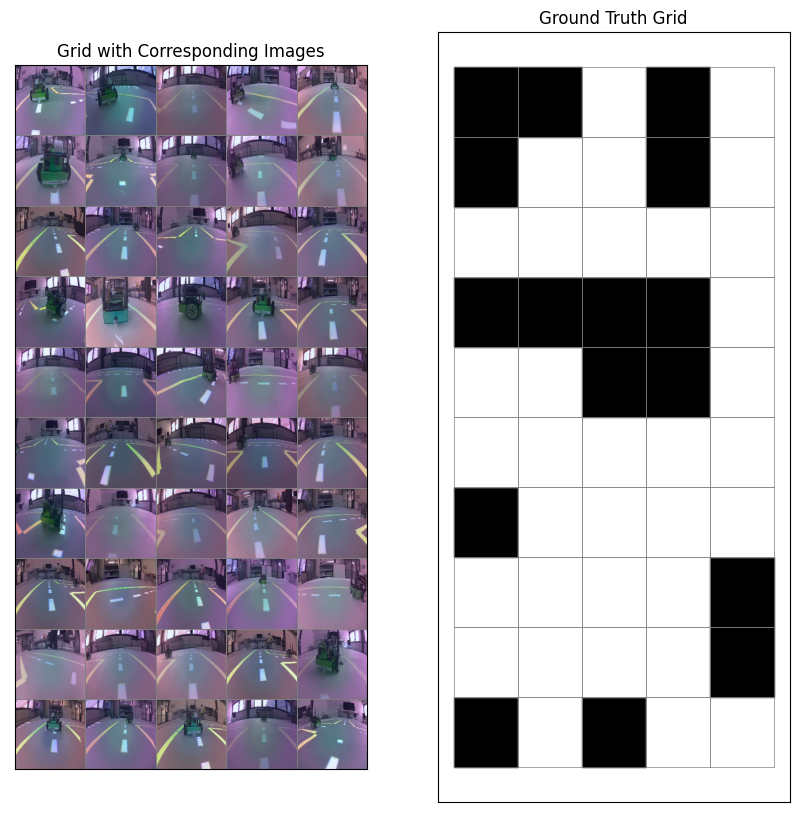

In [31]:
# Randomly select m * n images from the train + test dataset (with blocked or free images) to create a gridworld maze (some grids are blocked and some are free)
import numpy as np
m, n = 10, 5
images = []
for i in range(m * n):
    idx = np.random.randint(0, len(train_dataset) + len(test_dataset))
    images.append((train_dataset if idx < len(train_dataset) else test_dataset)[idx % len(train_dataset)])
# Create a grid with blocked (1) and free (0) cells
grid = np.zeros((m, n), dtype=int)
for i in range(m):
    for j in range(n):
        # create grids based on image labels
        if images[i * n + j][1] == 0:  # Assuming label 0 is blocked
            grid[i, j] = 1
        else:  # Assuming label 1 is free
            grid[i, j] = 0


# plot the ground truth grid
import matplotlib.pyplot as plt
def plot_grid(grid):
    fig, axes = plt.subplots(1, 2, figsize=(10, 10))
    # Plot the grid with corresponding images
    ax = axes[0]
    for i in range(m):
        for j in range(n):
            img, label = images[i * n + j]
            img = img.permute(1, 2, 0).numpy()  # Convert tensor to numpy array
            img = (img - img.min()) / (img.max() - img.min())  # Normalize for visualization
            ax.imshow(img, extent=(j, j + 1, i, i + 1))
            ax.plot([j, j + 1], [i, i], color='gray', linewidth=0.5)  # Top boundary
            ax.plot([j, j + 1], [i + 1, i + 1], color='gray', linewidth=0.5)  # Bottom boundary
            ax.plot([j, j], [i, i + 1], color='gray', linewidth=0.5)  # Left boundary
            ax.plot([j + 1, j + 1], [i, i + 1], color='gray', linewidth=0.5)  # Right boundary
    ax.set_title("Grid with Corresponding Images")
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Plot the ground truth grid
    ax = axes[1]
    for i in range(m):
        for j in range(n):
            val = grid[i, j]
            if val == 0:
                color = 'white'
            else:
                color = 'black'
            ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color))
            ax.plot([j, j + 1], [i, i], color='gray', linewidth=0.5)  # Top boundary
            ax.plot([j, j + 1], [i + 1, i + 1], color='gray', linewidth=0.5)  # Bottom boundary
            ax.plot([j, j], [i, i + 1], color='gray', linewidth=0.5)  # Left boundary
            ax.plot([j + 1, j + 1], [i, i + 1], color='gray', linewidth=0.5)  # Right boundary
    ax.set_title("Ground Truth Grid")
    ax.set_xticks([])
    ax.set_yticks([])
    
    
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
plot_grid(grid)

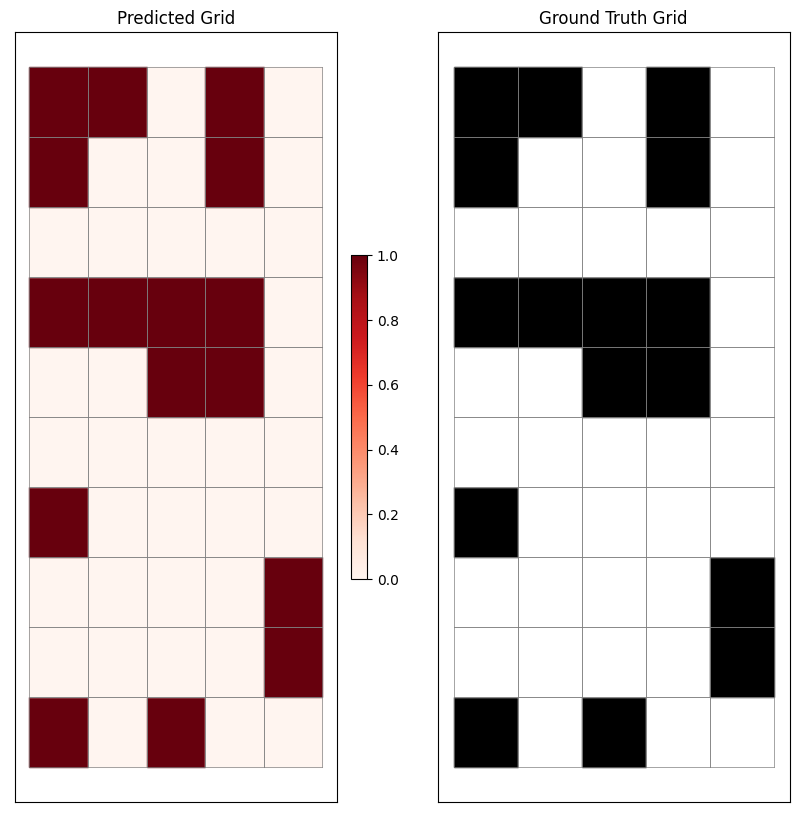

In [43]:
# Load the best model (best_model_resnet18.pth) and predict the gridworld (probability of each cell being blocked or free)
BEST_MODEL_PATH = 'best_model_resnet18.pth'

model = models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(512, 2)
device = torch.device('cpu')
model = model.to(device)
model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=torch.device('cpu')))
model.eval()
predictions = []
for img, _ in images:
    img = img.unsqueeze(0).to(device)  # Add batch dimension and move to device
    with torch.no_grad():
        output = model(img)
        prediction = output.argmax(1).item()  # Get the predicted class
        predictions.append(prediction)
# Convert predictions to a grid
predicted_grid = np.array(predictions).reshape(m, n)


# Plot the predicted grid
def plot_predicted_grid_with_ground_truth(predicted_grid, ground_truth_grid):
    fig, axes = plt.subplots(1, 2, figsize=(10, 10))
    
    # Plot the predicted grid
    ax = axes[0]
    for i in range(m):
        for j in range(n):
            val = predicted_grid[i, j]
            ax.add_patch(plt.Rectangle((j, i), 1, 1, color=plt.cm.Reds(1.0 - (val / 1.0))))  # Normalize val to [0, 1] for colormap
            ax.plot([j, j + 1], [i, i], color='gray', linewidth=0.5)  # Top boundary
            ax.plot([j, j + 1], [i + 1, i + 1], color='gray', linewidth=0.5)  # Bottom boundary
            ax.plot([j, j], [i, i + 1], color='gray', linewidth=0.5)  # Left boundary
            ax.plot([j + 1, j + 1], [i, i + 1], color='gray', linewidth=0.5)  # Right boundary
    ax.set_title("Predicted Grid")
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Add color bar for predicted grid
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    
    # Plot the ground truth grid
    ax = axes[1]
    for i in range(m):
        for j in range(n):
            val = ground_truth_grid[i, j]
            color = 'white' if val == 0 else 'black'
            ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color))
            ax.plot([j, j + 1], [i, i], color='gray', linewidth=0.5)  # Top boundary
            ax.plot([j, j + 1], [i + 1, i + 1], color='gray', linewidth=0.5)  # Bottom boundary
            ax.plot([j, j], [i, i + 1], color='gray', linewidth=0.5)  # Left boundary
            ax.plot([j + 1, j + 1], [i, i + 1], color='gray', linewidth=0.5)  # Right boundary
    ax.set_title("Ground Truth Grid")
    ax.set_xticks([])
    ax.set_yticks([])
    
    plt.show()

plot_predicted_grid_with_ground_truth(predicted_grid, grid)
